In [1]:
import rasterio
from rasterio.transform import array_bounds
import geopandas as gpd
from shapely.geometry import Point

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

from pathlib import Path
from tqdm import tqdm
import networkx as nx

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import colors, colorbar, cm
from matplotlib.colors import LinearSegmentedColormap

from orinoco import get_cropped_profile

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)

# Load Data

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir_4326 = Path(f'{products_for_map_dir}_4326')


In [3]:
plot_dir = Path('plots')
plots_for_maps_dir = plot_dir/f'{map_name}'
plots_for_maps_dir.mkdir(exist_ok=True, parents=True)

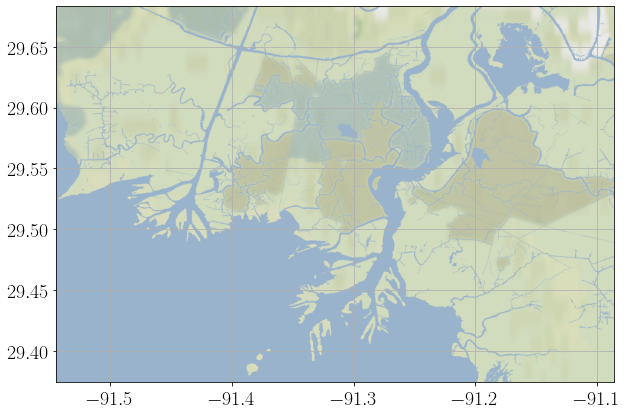

In [4]:
from rasterio import plot

fig, ax = plt.subplots(figsize=(10, 10))

with rasterio.open(products_for_map_dir_4326/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(products_for_map_dir_4326/'water_mask.tif') as ds:
    water_mask = ds.read(1)

with rasterio.open(products_for_map_dir_4326/f'{map_name}.tif') as ds:
    stamen_arr = ds.read()
    transform = ds.transform
    profile = ds.profile

plot.show(stamen_arr, ax=ax, transform=transform)
ax.grid('on', zorder=2)
ds.close()

/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the 

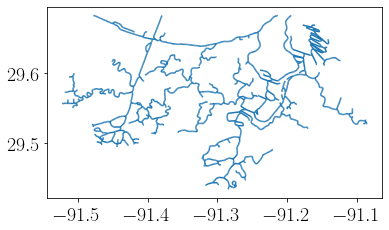

In [5]:
nodes_df = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson').to_crs({'init':'epsg:4326'})
edges_df = gpd.read_file(products_for_map_dir/'orinoco_edges.geojson').to_crs({'init':'epsg:4326'})
widths_df = gpd.read_file(products_for_map_dir/'width_geometries.geojson').to_crs({'init':'epsg:4326'})
widths_df = widths_df[~widths_df.geometry.is_empty]

edges_df.plot()

# Plot

In [6]:
ocean_layer = ocean_mask.astype(dtype=float)
ocean_layer[~ocean_mask.astype(bool)] = np.nan

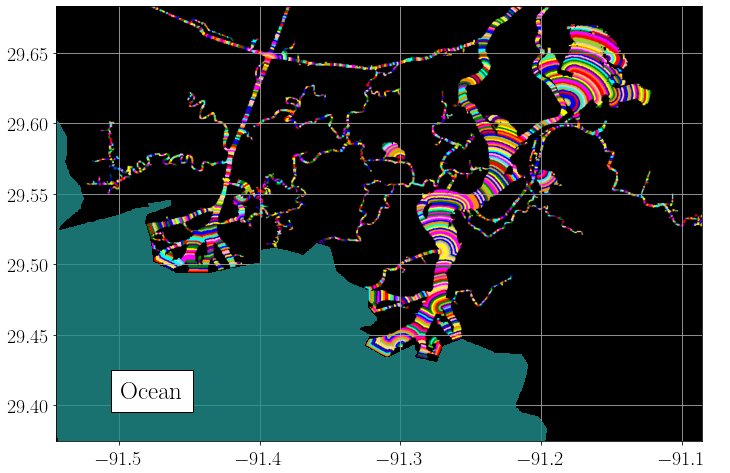

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
ds = rasterio.open(products_for_map_dir_4326/'segments_rgb.tif')
plot.show(ds.read(), ax=ax, transform=ds.transform, zorder=1)
plot.show(ocean_layer, ax=ax, transform=ds.transform, zorder=2, cmap='viridis', vmin=0, vmax=2, alpha=.8)
ax.grid('on', zorder=5)

#########
# Textbox
#########

t = ax.text(.1, .1, 
            r"Ocean", 
            c='black',
            size=25,
            transform=ax.transAxes,
            zorder=4)

t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black', pad=10))


################
# Empty Colorbar
###############

# To match size of other figures

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2.5%', pad=0.07)
cax.axis('off')


plt.savefig(plots_for_maps_dir/'segments.png')
ds.close()

/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


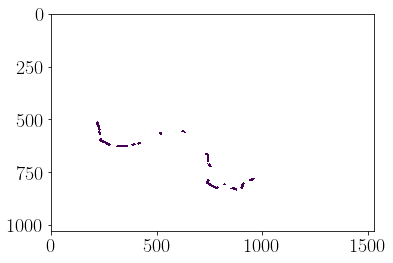

In [8]:
with rasterio.open(products_for_map_dir_4326/'distance.tif') as ds:
    distance = ds.read(1)
    transform = ds.transform
    
interface = (distance.copy() < 200)
interface = nd.binary_dilation(interface.astype(int), iterations=3).astype(float)
interface[~(interface >0)] = np.nan
plt.imshow(interface, interpolation='none')

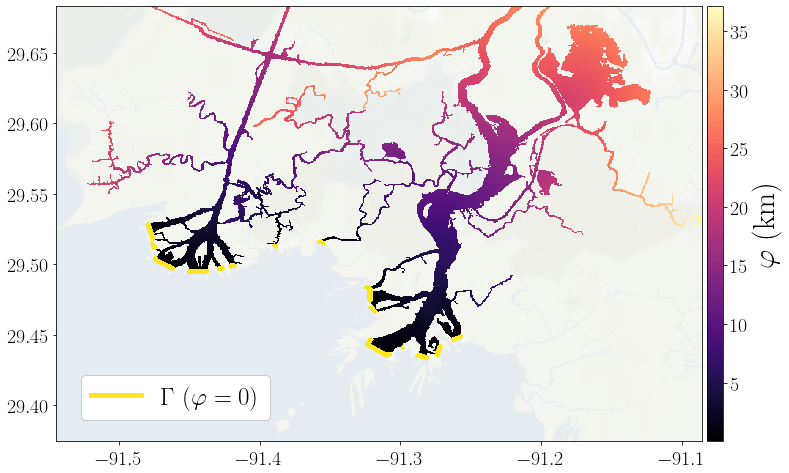

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))


plot.show(interface, ax=ax, transform=ds.transform, 
          zorder=2, cmap='viridis',vmin=0, vmax=1, interpolation='none')
cmap = 'magma'
D = distance/1_000
plot.show(distance/1_000, ax=ax, transform=ds.transform, zorder=1, cmap=cmap, interpolation='none')
plot.show(stamen_arr, ax=ax, transform=ds.transform, zorder=0, alpha=.25)


##########
# Colorbar
##########

# Source: https://matplotlib.org/3.1.0/tutorials/colors/colorbar_only.html

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2.5%', pad=0.07)

norm = colors.Normalize(vmin=np.nanmin(D), vmax=np.nanmax(D))
cb1 = colorbar.ColorbarBase(cax, 
                            cmap=plt.get_cmap(cmap),
                            norm=norm,
                            orientation='vertical')
cax.set_ylabel(r'$\varphi$ (km)', fontsize=30)
cax.tick_params(axis='both', which='major', labelsize=20)


########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          color=scalarMap.to_rgba(1),
                          label=r'$\Gamma$ ($\varphi=0$)',
                          linewidth=5,
                          markersize=10,
                          )]
ax.legend(handles=legend_elements,
          bbox_to_anchor=(.35, .18), 
          fontsize=25,  
          framealpha=1)


plt.savefig(plots_for_maps_dir/'distance.png')

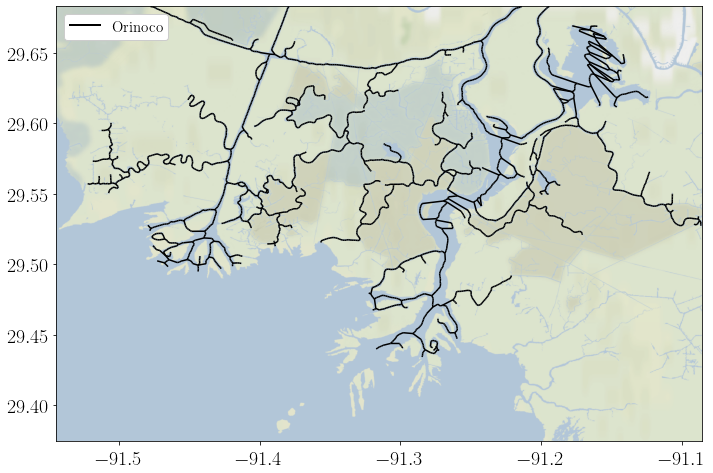

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

plot.show(stamen_arr, ax=ax, transform=ds.transform, zorder=0, alpha=.75)
edges_df.plot(ax=ax, zorder=1, color='black')


########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='black',
                          label='Orinoco',
                          linewidth=2,
                          markersize=10)]

ax.legend(handles=legend_elements, loc='upper left', fontsize=15, framealpha=1)

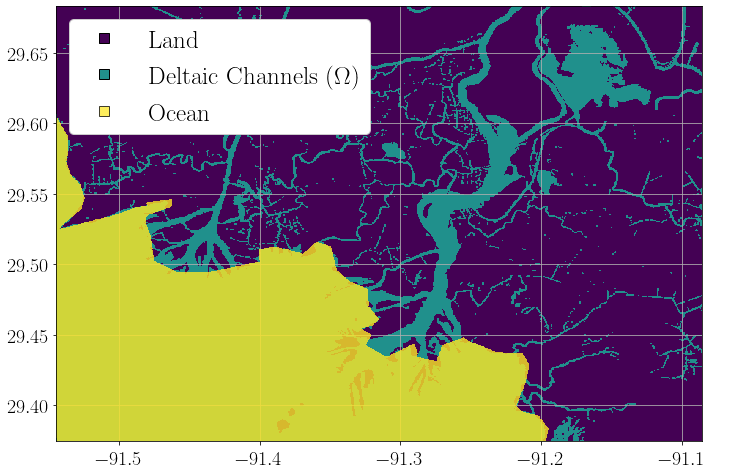

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
plot.show(water_mask, ax=ax, transform=transform, zorder=1,  vmin=0, vmax=2, interpolation='none')
plot.show(ocean_layer, ax=ax, transform=transform, zorder=2, cmap='viridis', vmin=0, vmax=1, alpha=.8, interpolation='none')
ax.grid('on', zorder=5)



########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

M = 3
labels = ['Land', 'Deltaic Channels ($\Omega$)', 'Ocean']
cNorm  = colors.Normalize(vmin=0, vmax=(M-1))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          alpha=alpha,
                          markersize=10) for alpha, k in zip([1, 1, .75], range(M))]
ax.legend(handles=legend_elements, loc='upper left', fontsize=25,  framealpha=1)


################
# Empty Colorbar
###############

# To match size of other figures

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2.5%', pad=0.07)
cax.axis('off')


plt.savefig(plots_for_maps_dir/'landcover_init.png')

# Cropped for channel Network

In [25]:
# Atchafalaya
if True:
    sy = np.s_[250:1000]
    sx = np.s_[600:1150]
# Wax Lake
else:
    sy = np.s_[250:750]
    sx = np.s_[150:650]
    


In [ ]:
profile_cropped = get_cropped_profile(profile, sx, sy)
transform_c = profile_cropped['transform']

x_min, y_min, x_max, y_max = array_bounds(profile_cropped['height'], 
                                          profile_cropped['width'], 
                                          profile_cropped['transform'])

In [26]:
edges_c = edges_df.cx[x_min: x_max, y_min: y_max].copy()
nodes_c = nodes_df.cx[x_min: x_max, y_min: y_max].copy()
widths_c = widths_df.cx[x_min: x_max, y_min: y_max].copy()


stamen_arr_c = stamen_arr[:, sy, sx]
ocean_layer_c = ocean_layer[sy, sx]
water_mask_c = water_mask[sy, sx]

In [27]:
chanG = nx.read_gpickle(products_for_map_dir/'channel_network.pkl')
nodes = [(data['x'], data['y']) for data in nodes_c.to_dict('records')]
H = chanG.subgraph(nodes)
type(H), len(H), list(H.nodes())[0]

(networkx.classes.digraph.DiGraph,
 1044,
 (669639.483394834, 3269571.5867158673))

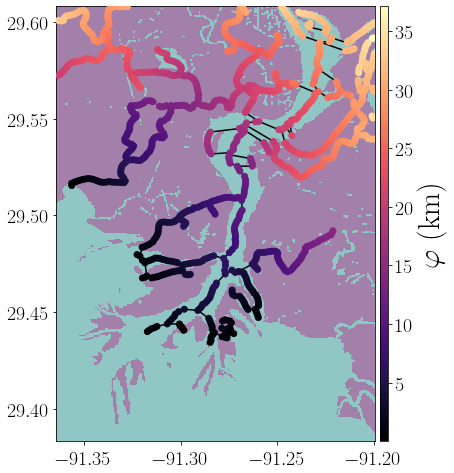

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

edges_c.plot(color='black', ax=ax, alpha=1,zorder=2)
nodes_c['km_to_coast'] = (nodes_c.meters_to_interface.values) / 1_000
nodes_c.plot(column='km_to_coast', ax=ax, cmap='magma', zorder=3, linewidth=1)


##########
# Colorbar
##########

# Source: https://matplotlib.org/3.1.0/tutorials/colors/colorbar_only.html

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2.5%', pad=0.07)

norm = colors.Normalize(vmin=np.nanmin(D), vmax=np.nanmax(D))
cb1 = colorbar.ColorbarBase(cax, 
                            cmap=plt.get_cmap(cmap),
                            norm=norm,
                            orientation='vertical')
cax.set_ylabel(r'$\varphi$ (km)', fontsize=30)
cax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig(plots_for_maps_dir/'cropped_node_dist.png')

In [29]:
with rasterio.open(products_for_map_dir/'segments.tif') as ds:
    original_crs = dict(ds.crs)
original_crs

{'init': 'epsg:32615'}

In [30]:
nodes_df['geometry_coords'] =nodes_df['geometry'].map(lambda point: point.coords[0])
nodes_df['geometry_coords_original'] = nodes_df['geometry'].to_crs(original_crs).map(lambda point: point.coords[0])

pos_r = nodes_df.set_index('geometry_coords_original').to_dict()['geometry_coords']


/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


To plot the graph, we need it in 'epsg:4326'. Unfortunately, using pyproj directly is slow, so we we circuitously use the geopandas API as below.

In [31]:
# Slower, but equivalent

# from pyproj import Proj, transform
# inProj = Proj(init=original_crs)
# outProj = Proj(init='epsg:4326')
# pos_r = {node: transform(inProj,outProj,*node) for node in H.nodes()}

geom = list(map(lambda p: Point(*p), H.nodes()))
nodes_df_temp = gpd.GeoDataFrame(geometry=geom, crs=original_crs)
nodes_df_temp['geometry_r'] = nodes_df_temp.geometry.to_crs({'init':'epsg:4326'})
nodes_df_temp['geometry_r_coords'] = nodes_df_temp['geometry_r'].map(lambda p: p.coords[0])
nodes_df_temp['geometry_coords'] = nodes_df_temp['geometry'].map(lambda p: p.coords[0])
nodes_df_temp.head()

/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,geometry,geometry_r,geometry_r_coords,geometry_coords
0,POINT (669639.483 3269571.587),POINT (-91.24921 29.54431),"(-91.2492094317686, 29.54431318773712)","(669639.483394834, 3269571.5867158673)"
1,POINT (663980.682 3270868.182),POINT (-91.30740 29.55677),"(-91.30739546575543, 29.556766721974785)","(663980.6818181818, 3270868.1818181816)"
2,POINT (661812.097 3266806.452),POINT (-91.33037 29.52041),"(-91.33037386934717, 29.520407544066398)","(661812.0967741936, 3266806.4516129033)"
3,POINT (662344.318 3272353.409),POINT (-91.32406 29.57038),"(-91.32405869830717, 29.57037955992221)","(662344.3181818182, 3272353.409090909)"
4,POINT (663684.821 3269028.571),POINT (-91.31072 29.54021),"(-91.3107242982341, 29.54020993505405)","(663684.8214285715, 3269028.5714285714)"


In [32]:
pos_r = nodes_df_temp.set_index('geometry_coords').to_dict()['geometry_r_coords']

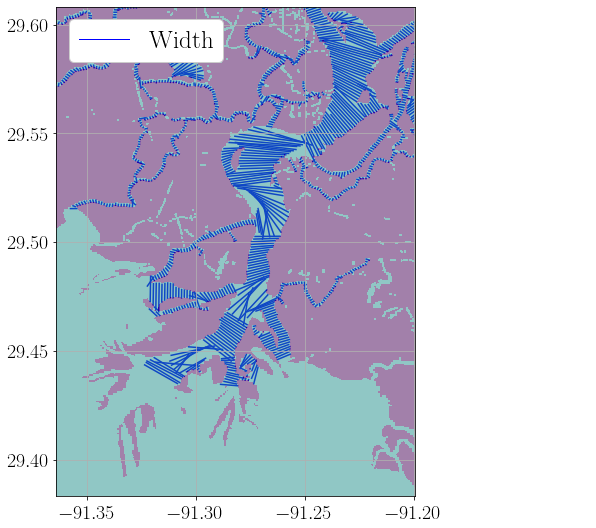

In [33]:
fig, ax = plt.subplots(figsize=(13, 9))

plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

widths_c.plot(color='blue', ax=ax, zorder=1)



ax.axis('on')
cax = fig.add_axes([0.85, 0.13, 0.04, 0.74])
cax.axis('off')

legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='blue',
                          label='Width',
                          linewidth=1,
                          markersize=10)]

ax.legend(handles=legend_elements, loc='upper left', fontsize=25, framealpha=1)

ax.grid('on')

plt.savefig(plots_for_maps_dir/'cropped_widths.png')

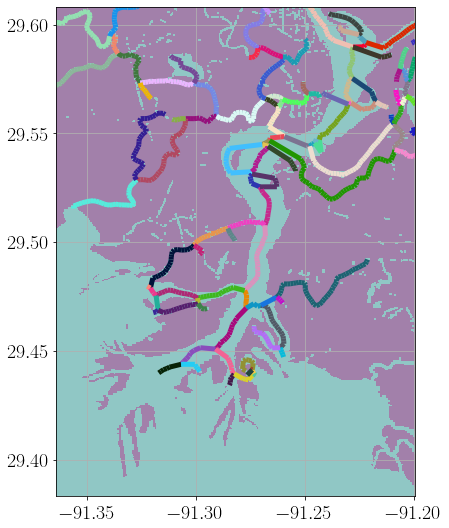

In [34]:
fig, ax = plt.subplots(figsize=(13, 9))

plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

#############
# Random Cmap
#############

# Source: https://stackoverflow.com/a/32520273/2348348

np.random.seed(0)
N = edges_c.shape[0]
color_list = [np.random.random(3) for k in range(N)]
random_colormap = LinearSegmentedColormap.from_list('new_map', color_list, N)


edges_c.plot(column='segment_id', 
             cmap = random_colormap,
             categorical=True,
             ax=ax, 
             zorder=2, 
             linewidth=5)


ax.grid('on')
plt.savefig(plots_for_maps_dir/'cropped_junction_segments.png')

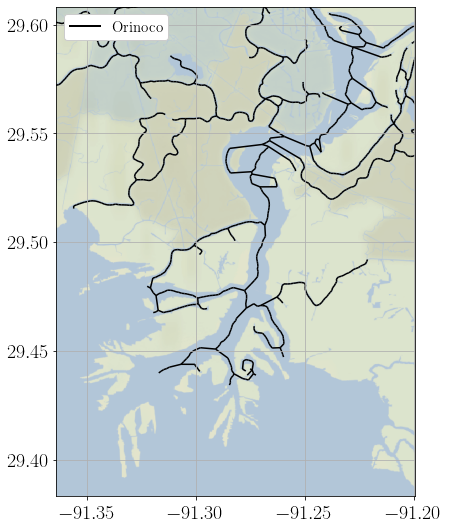

In [35]:
fig, ax = plt.subplots(figsize=(13, 9))

plot.show(stamen_arr_c, ax=ax, transform=transform_c, zorder=0, alpha=.75)
edges_c.plot(ax=ax, zorder=1, color='black')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='black',
                          label='Orinoco',
                          linewidth=2,
                          markersize=10)]
ax.grid('on')
ax.legend(handles=legend_elements, loc='upper left', fontsize=15, framealpha=1)

# Redoing the stream flow figure

In [36]:
from orinoco import dfs_line_search

interface_nodes = [node for node, data in H.nodes(data=True) if data['interface_adj']]
node_data = dict(H.nodes(data=True))

def dfs_line_search_with_interface(G, source):
    def interface_criterion(node):
        return node_data[node]['interface_adj']
    return dfs_line_search(G, source, break_func=interface_criterion)

random_source = interface_nodes[0]

lines = list(dfs_line_search_with_interface(H.to_undirected(), random_source))

edges_with_arrows_0 = [line[len(line)//3] for line in lines 
                     if len(line) > 2]
edges_with_arrows_1 = [line[len(line)//3] for line in lines 
                     if (node_data[line[-1][0]]['interface_adj']) | (node_data[line[-1][1]]['interface_adj'])]
edges_with_arrows = edges_with_arrows_0 + edges_with_arrows_1
len(edges_with_arrows)

93

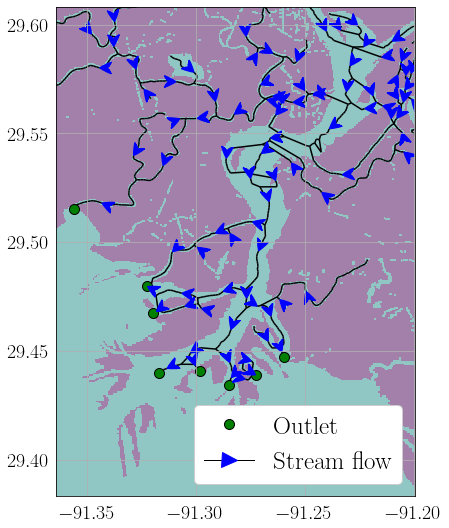

In [37]:
fig, ax = plt.subplots(figsize=(13, 9))
plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=0,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

edges_c.plot(color='black', ax=ax, zorder=1)
nodes_c[nodes_c.interface_adj].plot(color='green', ax=ax, zorder=1, markersize=100, edgecolor='black')

ins, outs = zip(*edges_with_arrows)
H2 = H.subgraph(list(set(ins + outs)))


nx.draw_networkx_edges(H2, 
                        pos=pos_r,
                        width=1.2,
                        edge_list=edges_with_arrows,
                        node_size=1,
                        arrows=True,
                        arrowstyle="fancy",
                        arrowsize=28,
                        ax=ax,
                        edge_color='blue',
                        zorder=1,
                        alpha=1,
                       )


########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

legend_elements = [Line2D([0], 
                          [0], 
                          marker='o',
                          color='w',
                          label=f'Outlet',
                          markerfacecolor='green',
                          markeredgecolor='black',
                          alpha=1,
                          markersize=10)]

legend_elements += [Line2D([0], 
                           [0], 
                           marker='>',
                           color='black',
                           markerfacecolor='blue',
                           markeredgecolor='blue',
                           label='Stream flow',
                           linewidth=1,
                           markersize=15)]
ax.legend(handles=legend_elements, loc='lower right', fontsize=25,  framealpha=1)

ax.grid('on')
ax.tick_params(axis='both',
               which='major',
               labelbottom=True,
               labelleft=True)


plt.savefig(plots_for_maps_dir/'cropped_net_dir.png')